# Deeplabcut analysis

## Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import umap
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [2]:
path_to_extracted_folder = 'E:/deeplabcut/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('E:/deeplabcut/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('E:/deeplabcut/' + file, header=[1,2]) for file in pfa_files]

In [3]:
frame_info_df_manual = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')

### data cropping to keep 54000 frames in each session

In [4]:
def crop_dataframe(df, file_name):
    # Extract the mouse name from the filename, stripping extensions or additional characters if needed
    mouse_name = file_name.split('DLC')[0].rstrip('_')
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == mouse_name]['Start'].values[0]
    return df.iloc[start_frame : start_frame + 54000]

saline_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(saline_dataframes, saline_files)]
pfa_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(pfa_dataframes, pfa_files)]


## Step 3: Data Cleaning

In [14]:
def clean_data_modified(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Replace missing values or NaN with interpolation on the copy
    df_copy.interpolate(method='linear', inplace=True, limit_direction='both')
    
    return df_copy

# Applying the modified function to the cropped dataframes
saline_dataframes_cleaned = [clean_data_modified(df) for df in saline_dataframes_cropped]
pfa_dataframes_cleaned = [clean_data_modified(df) for df in pfa_dataframes_cropped]


In [15]:
# List of specified body parts
body_parts = ['head', 'leftEar', 'rightEar', 'centerofMass', 'leftHip', 'rightHip', 'tailRoot']

def compute_center_coordinates(df):
    # Extracting x and y coordinates for the specified body parts
    x_coords = df.loc[:, pd.IndexSlice[body_parts, 'x']]
    y_coords = df.loc[:, pd.IndexSlice[body_parts, 'y']]
    
    # Computing average x and y coordinates across the body parts for each frame
    df['center_x'] = x_coords.median(axis=1)
    df['center_y'] = y_coords.median(axis=1)
    
    return df

# Applying the function to all dataframes in both conditions
saline_dataframes = [compute_center_coordinates(df) for df in saline_dataframes]
pfa_dataframes = [compute_center_coordinates(df) for df in pfa_dataframes]

# Checking the first few rows of the first dataframe in the saline condition to verify the new columns
saline_dataframes[0].head()


bodyparts miniscope_head                              snout               
       coords              x           y likelihood           x           y   
181       181     463.577698  334.796692   0.999999  474.222961  322.601166  \
182       182     463.958710  334.923370   0.999999  476.340912  326.292297   
183       183     461.444794  330.246124   0.999991  470.177673  334.400024   
184       184     461.481567  328.865082   0.999994  471.184387  331.755127   
185       185     461.482910  328.865753   0.999994  471.192413  331.753265   

                      head                         ...    tailRoot              
    likelihood           x           y likelihood  ...           y likelihood   
181   0.999033  467.926422  304.436188   0.999973  ...  206.621490   1.000000  \
182   0.999516  470.070007  305.324341   0.999858  ...  206.403625   0.999999   
183   0.999718  465.845093  304.072815   0.999847  ...  206.778961   0.999999   
184   0.999594  466.467285  303.245453   0.999949  ...  206.811188   0.999999   
185   0.999592  466.470551  303.242554   0.999949  ...  206.811356   0.999999   

        tailMid                            tailEnd                          
              x           y likelihood           x           y likelihood   
181  508.380920  175.208115   0.999982  560.077942  174.593994   0.999982  \
182  507.639740  175.320770   0.999981  560.558044  173.919510   0.999963   
183  506.565002  175.478165   0.999983  557.498901  175.276810   0.999899   
184  506.739594  175.250504   0.999979  557.478455  175.722534   0.999898   
185  506.742065  175.250336   0.999979  557.476257  175.727051   0.999898   

       center_x    center_y  
                             
181  465.721344  251.123093  
182  464.764313  248.870392  
183  465.023499  246.110321  
184  465.021606  246.030380  
185  465.021667  246.028946  

[5 rows x 39 columns]

In [26]:
df_box_adjusted

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0        322       426.0      -225.0        958.0       -225.0  \
1    322_sal       431.5      -226.5        965.5       -226.5   
2        326       427.5      -225.0        959.5       -225.0   
3    326_pfa       423.0      -221.5        956.0       -221.5   
4        327       428.0      -227.0        962.0       -227.0   
5    327_pfa       422.5      -226.5        956.5       -226.5   
6        328       423.5      -228.5        958.5       -228.5   
7    328_sal       423.5      -227.5        957.5       -227.5   
8        330       427.5      -225.0        960.5       -225.0   
9    330_sal       424.5      -222.5        958.5       -222.5   
10       332       425.5      -225.0        959.5       -225.0   
11   332_sal       426.5      -222.0        958.5       -222.0   
12       334       425.0      -226.0        960.0       -226.0   
13   334_pfa       423.0      -224.0        957.0       -224.0   
14       335       424.0      -226.5        958.0       -226.5   
15   335_pfa       424.0      -222.0        957.0       -222.0   
16       336       426.5      -226.0        960.5       -226.0   
17   336_pfa       396.0      -261.5        930.0       -261.5   

    bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y   
0            958.0           839.0          426.0          839.0  \
1            965.5           841.5          431.5          841.5   
2            959.5           839.0          427.5          839.0   
3            956.0           844.5          423.0          844.5   
4            962.0           841.0          428.0          841.0   
5            956.5           841.5          422.5          841.5   
6            958.5           841.5          423.5          841.5   
7            957.5           840.5          423.5          840.5   
8            960.5           841.0          427.5          841.0   
9            958.5           845.5          424.5          845.5   
10           959.5           843.0          425.5          843.0   
11           958.5           842.0          426.5          842.0   
12           960.0           844.0          425.0          844.0   
13           957.0           844.0          423.0          844.0   
14           958.0           841.5          424.0          841.5   
15           957.0           844.0          424.0          844.0   
16           960.5           842.0          426.5          842.0   
17           930.0           806.5          396.0          806.5   

    box_center_x  box_center_y  
0          692.0         307.0  
1          698.5         307.5  
2          693.5         307.0  
3          689.5         311.5  
4          695.0         307.0  
5          689.5         307.5  
6          691.0         306.5  
7          690.5         306.5  
8          694.0         308.0  
9          691.5         311.5  
10         692.5         309.0  
11         692.5         310.0  
12         692.5         309.0  
13         690.0         310.0  
14         691.0         307.5  
15         690.5         311.0  
16         693.5         308.0  
17         663.0         272.5

In [27]:
df_box

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0        322         430         172          962          180  \
1    322_sal         433         174          967          180   
2        326         429         175          961          177   
3    326_pfa         426         178          959          184   
4        327         432         173          966          181   
5    327_pfa         425         172          959          181   
6        328         427         169          962          182   
7    328_sal         427         172          961          179   
8        330         429         174          962          180   
9    330_sal         427         177          961          184   
10       332         428         174          962          182   
11   332_sal         430         176          962          184   
12       334         429         174          964          182   
13   334_pfa         427         175          961          184   
14       335         428         173          962          180   
15   335_pfa         427         176          960          184   
16       336         428         175          962          180   
17   336_pfa         398         142          932          142   

    bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y   
0              954             442            422            434  \
1              964             441            430            435   
2              958             439            426            437   
3              953             445            420            439   
4              958             441            424            433   
5              954             443            420            434   
6              955             444            420            431   
7              954             441            420            434   
8              959             442            426            436   
9              956             446            422            439   
10             957             444            423            436   
11             955             444            423            436   
12             956             444            421            436   
13             953             445            419            436   
14             954             442            420            435   
15             954             446            421            438   
16             959             441            425            436   
17             928             403            394            403   

    box_center_x  box_center_y  
0          692.0         307.0  
1          698.5         307.5  
2          693.5         307.0  
3          689.5         311.5  
4          695.0         307.0  
5          689.5         307.5  
6          691.0         306.5  
7          690.5         306.5  
8          694.0         308.0  
9          691.5         311.5  
10         692.5         309.0  
11         692.5         310.0  
12         692.5         309.0  
13         690.0         310.0  
14         691.0         307.5  
15         690.5         311.0  
16         693.5         308.0  
17         663.0         272.5

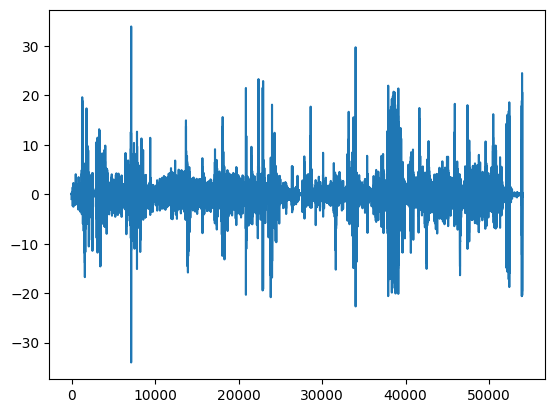

In [31]:
plt.plot(np.diff(saline_dataframes[0]['center_x']))

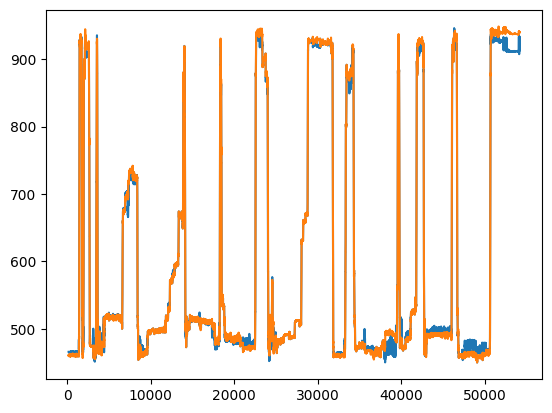

In [16]:
plt.plot(saline_dataframes[0]['center_x'])
plt.plot(saline_dataframes[0]['centerofMass']['x'])

## Behavior box center calculation

In [17]:
df_box = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

In [19]:
def calculate_center(row):
    box_center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    box_center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    return box_center_x, box_center_y

df_box['box_center_x'], df_box['box_center_y'] = zip(*df_box.apply(calculate_center, axis=1))


In [25]:
def adjust_coordinates(row):
    # Calculate width and length of the box
    width = row['top_right_x'] - row['top_left_x']
    length = row['bottom_left_y'] - row['top_left_y']
    
    # Calculate the center of the box
    center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    
    # Adjust coordinates if aspect ratio isn't met
    if length != 2 * width:
        width = width
        length = 2 * width
        row['top_left_x'] = center_x - width / 2
        row['top_right_x'] = center_x + width / 2
        row['bottom_left_x'] = center_x - width / 2
        row['bottom_right_x'] = center_x + width / 2
        row['top_left_y'] = center_y - length / 2
        row['top_right_y'] = center_y - length / 2
        row['bottom_left_y'] = center_y + length / 2
        row['bottom_right_y'] = center_y + length / 2

    return row

# Adjusting the coordinates in df_box
df_box_adjusted = df_box.apply(adjust_coordinates, axis=1)


In [28]:
import pandas as pd
import numpy as np

# Load the CSV data
df_box_coordinates = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

def compute_sub_rectangles(row):
    # Extract coordinates
    tl = np.array([row['top_left_x'], row['top_left_y']])
    tr = np.array([row['top_right_x'], row['top_right_y']])
    br = np.array([row['bottom_right_x'], row['bottom_right_y']])
    bl = np.array([row['bottom_left_x'], row['bottom_left_y']])
    
    # Calculate the vectors representing the sides
    top_vector = (tr - tl) / 8
    bottom_vector = (br - bl) / 8
    left_vector = (bl - tl) / 4
    right_vector = (br - tr) / 4
    
    sub_rects = []
    
    for i in range(4):
        for j in range(8):
            # Calculate the vertices of each sub-rectangle
            sub_tl = tl + j * top_vector + i * left_vector
            sub_tr = sub_tl + top_vector
            sub_bl = sub_tl + left_vector
            sub_br = sub_bl + top_vector
            
            sub_rects.append({
                'mouse_NO.': row['mouse_NO.'],
                'top_left_x': sub_tl[0],
                'top_left_y': sub_tl[1],
                'top_right_x': sub_tr[0],
                'top_right_y': sub_tr[1],
                'bottom_right_x': sub_br[0],
                'bottom_right_y': sub_br[1],
                'bottom_left_x': sub_bl[0],
                'bottom_left_y': sub_bl[1],
            })
    
    return sub_rects

# Compute sub-rectangles for all rows
all_sub_rectangles = []
for _, row in df_box_coordinates.iterrows():
    all_sub_rectangles.extend(compute_sub_rectangles(row))

# Convert results to DataFrame
df_sub_rectangles = pd.DataFrame(all_sub_rectangles)

df_sub_rectangles.head()
df_sub_rectangles.to_csv

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y  bottom_right_x   
0       322       430.0       172.0        496.5        173.0           494.5  \
1       322       496.5       173.0        563.0        174.0           561.0   
2       322       563.0       174.0        629.5        175.0           627.5   
3       322       629.5       175.0        696.0        176.0           694.0   
4       322       696.0       176.0        762.5        177.0           760.5   

   bottom_right_y  bottom_left_x  bottom_left_y  
0           238.5          428.0          237.5  
1           239.5          494.5          238.5  
2           240.5          561.0          239.5  
3           241.5          627.5          240.5  
4           242.5          694.0          241.5

In [29]:
df_sub_rectangles

mouse_NO.  top_left_x  top_left_y  top_right_x  top_right_y   
0         322      430.00      172.00       496.50       173.00  \
1         322      496.50      173.00       563.00       174.00   
2         322      563.00      174.00       629.50       175.00   
3         322      629.50      175.00       696.00       176.00   
4         322      696.00      176.00       762.50       177.00   
..        ...         ...         ...          ...          ...   
571   336_pfa      595.25      337.75       662.00       337.75   
572   336_pfa      662.00      337.75       728.75       337.75   
573   336_pfa      728.75      337.75       795.50       337.75   
574   336_pfa      795.50      337.75       862.25       337.75   
575   336_pfa      862.25      337.75       929.00       337.75   

     bottom_right_x  bottom_right_y  bottom_left_x  bottom_left_y  
0            494.50           238.5         428.00          237.5  
1            561.00           239.5         494.50          238.5  
2            627.50           240.5         561.00          239.5  
3            694.00           241.5         627.50          240.5  
4            760.50           242.5         694.00          241.5  
..              ...             ...            ...            ...  
571          661.00           403.0         594.25          403.0  
572          727.75           403.0         661.00          403.0  
573          794.50           403.0         727.75          403.0  
574          861.25           403.0         794.50          403.0  
575          928.00           403.0         861.25          403.0  

[576 rows x 9 columns]

## Step 4: Calculate Euclidean Distance from Reference Point

In [34]:
def calculate_euclidean_distance(df):
    distance_df = pd.DataFrame()
    body_parts = [col for col in df.columns.get_level_values(0).unique() if col not in ['bodyparts', 'likelihood']]
    for body_part in body_parts:
        x = df[(body_part, 'x')]
        y = df[(body_part, 'y')]
        distance = np.sqrt(x**2 + y**2)
        distance_df[body_part] = distance
    return distance_df

saline_data_distance = [calculate_euclidean_distance(df) for df in saline_dataframes]
pfa_data_distance = [calculate_euclidean_distance(df) for df in pfa_dataframes]

In [45]:
saline_data_distance[1].shape

(56312, 12)

## Step 5: Apply PCA for Dimensionality Reduction (Optional, but can speed up t-SNE)

In [49]:
all_data_distance = pd.concat([pd.concat(saline_data_distance), pd.concat(pfa_data_distance)], axis=0)

# Ensure n_components is less than or equal to min(n_samples, n_features)
# n_components = min(50, all_data_distance.shape[0], all_data_distance.shape[1])
n_components = 2

pca = PCA(n_components=n_components)  
data_pca = pca.fit_transform(all_data_distance)


(511209, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

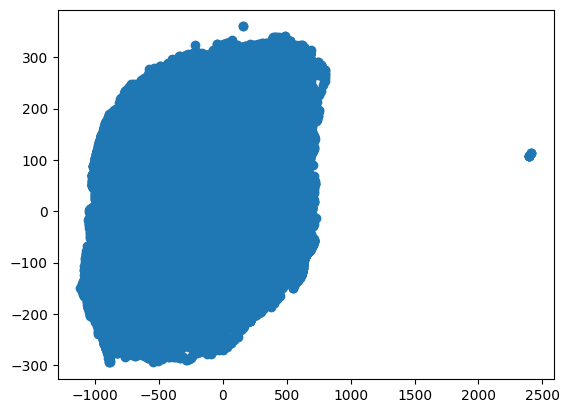

In [53]:
print(np.shape(data_pca))
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show

## Step 6: Apply t-SNE for Visualization

In [54]:
tsne = TSNE(n_components=2, perplexity=200)
data_tsne = tsne.fit_transform(all_data_distance)

plt.figure(figsize=(10, 6))
plt.scatter(data_tsne[:len(pd.concat(saline_data_distance)), 0], 
            data_tsne[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_tsne[len(pd.concat(saline_data_distance)):, 0], 
            data_tsne[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.title('t-SNE Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

## Step 7: Apply UMAP for Visualization

In [29]:
reducer = umap.UMAP(random_state=42)
data_umap = reducer.fit_transform(data_pca)

plt.figure(figsize=(10, 6))
plt.scatter(data_umap[:len(pd.concat(saline_data_distance)), 0], 
            data_umap[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_umap[len(pd.concat(saline_data_distance)):, 0], 
            data_umap[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='upper right')
plt.title('UMAP Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()

C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 